In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits
#import multiprocessing as mp
#import copy
#import datetime

In [5]:
def gen_obs():
    for args_inst in args_list:
        filt, mask, pupil = args_inst
        print(args_inst)

        bp = nrc_utils.read_filter(filt)
        #print(filt)
        if mask is None:
            #subsize = 320 if bp.avgwave()<24000 else 160
            subsize = 160
        else:
            subsize = 640 if '210R' in mask else 320
        
        #args_model = (None, 0.007, dist, 1.6, 'mJy/arcsec^2')
        kwargs = {'dist_out':dist, 'sptype':sptype, 'star_kmag':kmag}
        
        #print(subsize)
        
        m = 'none' if mask is None else mask
        p = 'none' if pupil is None else pupil
        key = '{}_{}_{}'.format(filt,m,p)
        try: obs_old = obs_dict[key]
        except: obs_old = None

        obs = pynrc.observe_star(args_inst, subsize=subsize, obs=obs_old, **kwargs)
        
        obs_dict[key] = obs
        print('')
        
def do_exp():
    # Update detector integration times
    args_210 = ('RAPID',10,43)
    args_335 = ('DEEP8', 10, 18)
    args_430 = ('DEEP8', 10, 18)
    args_W   = ('RAPID', 6, 180)
    args_M   = ('RAPID', 10, 108*4)
    
    for i, k in enumerate(filt_keys):
        print(k)
        obs = obs_dict[k]
        m='none' if obs.mask is None else obs.mask
        
        if '210R' in m:
            rm, ng, nint = args_210
        elif '335R' in m:
            rm, ng, nint = args_335
        elif '430R' in m:
            rm, ng, nint = args_430
        elif 'W' in k: # Wide Band imaging
            rm, ng, nint = args_W
        else: # Medium Band Imaging
            rm, ng, nint = args_M
            
        #rm, ng, nint = ('RAPID', 2, 500)

        v = True if i==0 else False
        obs.update_detectors(read_mode=rm, ngroup=ng, nint=nint, verbose=v)
        obs.obs_images(wfe_drift=10, verbose=True)
        if obs.mask is None: sens = obs.sensitivity(units='vegamag', nsig=1, verbose=True)
        print('')

#import matplotlib.patches as patches
def plot_contrast(key, nsig=5, age=10, entropy=10, xlim=None, ylim=None, ax=None, maglim=False):

    wfe_list = [0,1,2,5,10]
    
    pal1 = (sns.color_palette("deep", n_colors=5))[::-1]
    pal2 = (sns.color_palette("dark", n_colors=5))[::-1]
    blues = (sns.color_palette("Blues_d", n_colors=len(wfe_list)))[::-1]

    # Conrast curves for varying WFE
    #nsig=5
    #age = 10
    #entropy = 13
    
    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")

    obs = obs_dict[key] #key_keys[0]]
    con_dict = {}
    for wfe in wfe_list:
        rr, con = obs.get_contrast(wfe_drift=wfe, maglim=maglim, nsig=nsig)
        con_dict[wfe] = con

    # Flux contrast for various planet masses with range of Av
    mass_list = [10,5,2,1]
    pcon = np.zeros([len(mass_list)])
    for i,m in enumerate(mass_list):
        flux = obs.planet_flux(mass=m, age=age, entropy=entropy, atmo='hy3s')
        pcon[i] = flux/obs.hdu_image.max()
        if maglim: pcon[i] = obs.star_flux('vegamag') - 2.5*np.log10(pcon[i])

    if xlim is None:
        xlim = [0,5.1]

    # Plot all contrast curves
    ax_plot = ax.plot if maglim else ax.semilogy
    if ax is None: fig,ax = plt.subplots(1,1, figsize=(10, 5))
    for i,wfe in enumerate(wfe_list[::-1]):
        ax_plot(rr, con_dict[wfe], color=blues[i], label='WFE Drift = {} nm'.format(wfe))

    # Plot the rectangular regions
    for i,m in enumerate(mass_list):
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        ax.plot(xlim, [pcon[i]]*2, color=pal2[i], ls='--', lw=2, label=label)
    ax.legend(ncol=2)

    if ylim is not None: ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.minorticks_on()

    age_str = 'Age = {} Myr'.format(age)
    dist_str = 'Distance = {} pc'.format(dist)
    ent_str = entropy_string + ' Start' #Entropy = {}'.format(entropy)

    ax.set_title('{}; {}; {}; {}'.format(obs.filter,ent_str,age_str,dist_str))
    #ax.set_ylabel('{}-sigma Contrast'.format(nsig))
    #ax.set_xlabel('Separation (arcsec)')
    
def gen_plots(save_fig=False):
    
    nkey = len(filt_keys)
    fig,axes = plt.subplots(nkey,2, figsize=(14,4*nkey))

    entropy_list = [13,8]
    nsig=5

    xlim=[0,5.1]
    ylim=[25,5] #[1e-7,1e-2]

    for j,key in enumerate(filt_keys):

        for i,ax in enumerate(axes[j].flatten()):
            plot_contrast(key, nsig=nsig, age=age, entropy=entropy_list[i], 
                          ax=ax, ylim=ylim, xlim=xlim, maglim=True)
            ax.set_xlabel('Separation (arcsec)')
            #if i==0: ax.set_ylabel('{}-sigma Contrast'.format(nsig))
            if i==0: ax.set_ylabel('{}-sigma Sensitivites (mag)'.format(nsig))
            if i>0: ax.set_yticklabels([])
            if j<len(filt_keys)-1: ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.90, bottom=0.1 , left=0.05, right=0.97)
    texp = obs_dict[filt_keys[0]].multiaccum_times['t_exp']
    fig.suptitle('{} Contrast (t_exp = {:.0f} sec)'.format(source,texp), fontsize=16);
    
    if save_fig: fig.savefig(outdir+source+'.pdf')

In [3]:
# Argument list: (Name,         distance, sptype, age, kmag)
args_sources = [('M5V_100Myr_10pc', 10.0, 'M5V', 100,  6.50),
                ('LP944-20',         6.4, 'M9V', 200,  9.55),
                ('HIP17695',        16.1, 'M3V', 150,  6.93),
                ('G7-34',           13.6, 'M4V', 150,  8.18),
                ('2MJ0443+0002',    14.9, 'M9V',  24, 11.22),
                ('AP_Col',           8.4, 'M5V',  50,  6.87),
                ('2MJ0944-1220',    12.0, 'M5V',  50,  7.60),
                ('BD+01_2447',       7.1, 'M3V', 150,  5.31),
                ('AU_Mic',           9.9, 'M1V',  24,  4.53),
                ('FomalhautC',       7.6, 'M4V', 440,  7.21),
                ('2MJ2351+2344',    16.0, 'M4V',  24,  8.83)]

In [4]:
args_list = [('F277W', None, None),
             ('F356W', None, None),
             ('F444W', None, None),
             ('F405N', None, None)]

args_list = [('F200W', 'MASK335R', 'CIRCLYOT'),
             ('F356W', 'MASK335R', 'CIRCLYOT'), 
             ('F444W', 'MASK430R', 'CIRCLYOT')]

args_list = [('F356W', 'MASK335R', 'CIRCLYOT'), 
             ('F444W', 'MASK335R', 'CIRCLYOT')]


filt_keys = []
for f,m,p in args_list:
    if m is None: m = 'none'
    if p is None: p = 'none'
    filt_keys.append('{}_{}_{}'.format(f,m,p))
    
obs_dict = {}

In [8]:
source, dist, sptype, age, kmag = args_sources[1]
gen_obs()

('F356W', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F444W', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.



In [21]:
# Print out magnitudes

bp1 = nrc_utils.read_filter('F356W', pupil='MASK335R', mask='CIRCLYOT')
bp2 = nrc_utils.read_filter('F444W', pupil='MASK335R', mask='CIRCLYOT')

for (source, dist, sptype, age, kmag) in args_sources:

    sp = nrc_utils.stellar_spectrum(sptype)
    sp_norm = sp.renorm(kmag, 'vegamag', S.ObsBandpass('k'))
    obs1 = S.Observation(sp_norm, bp1, binset=bp1.wave)
    obs2 = S.Observation(sp_norm, bp2, binset=bp2.wave)
    
    print('{:16} {:5.2f} {:5.2f} {:5.2f}'.format(source, kmag, obs1.effstim('vegamag'), obs2.effstim('vegamag')))



M5V_100Myr_10pc   6.50  6.30  6.38
LP944-20          9.55  9.45  9.29
HIP17695          6.93  6.78  6.76
G7-34             8.18  8.01  8.03
2MJ0443+0002     11.22 11.12 10.96
AP_Col            6.87  6.67  6.75
2MJ0944-1220      7.60  7.40  7.48
BD+01_2447        5.31  5.16  5.14
AU_Mic            4.53  4.43  4.42
Fomalhaut         7.21  7.04  7.06
2MJ2351+2344      8.83  8.66  8.68


In [22]:
def do_all(save_fig=True):
    clear_output()
    
    print(source, dist, sptype, age, kmag)
    gen_obs()
    clear_output()
    
    print(source, dist, sptype, age, kmag)
    do_exp()
    gen_plots(save_fig=save_fig)

In [23]:
outdir  = '/Volumes/NIRData/MDwarfs/'
for (source, dist, sptype, age, kmag) in args_sources:
    do_all()
    plt.close()

    clear_output()

BD+01_2447 7.1 M3V 150 5.31
F356W_MASK335R_CIRCLYOT
New Ramp Settings:
  read_mode :    DEEP8
  nf        :        8
  nd2       :       12
  ngroup    :       10
  nint      :       18
New Detector Settings
  wind_mode :   WINDOW
  xpix      :      320
  ypix      :      320
  x0        :     1238
  y0        :     1502
New Ramp Times
  t_group   :   21.381
  t_frame   :    1.069
  t_int     :  200.980
  t_exp     : 3617.631
  t_acq     : 3636.874
Max Flux: 380.1 [365.8] counts/sec
Well Fill: 1.0 [1.0] times full well
SNR Max: 0.0

F444W_MASK335R_CIRCLYOT
Max Flux: 292.3 [266.1] counts/sec
Well Fill: 0.8 [0.7] times full well
SNR Max: 0.0



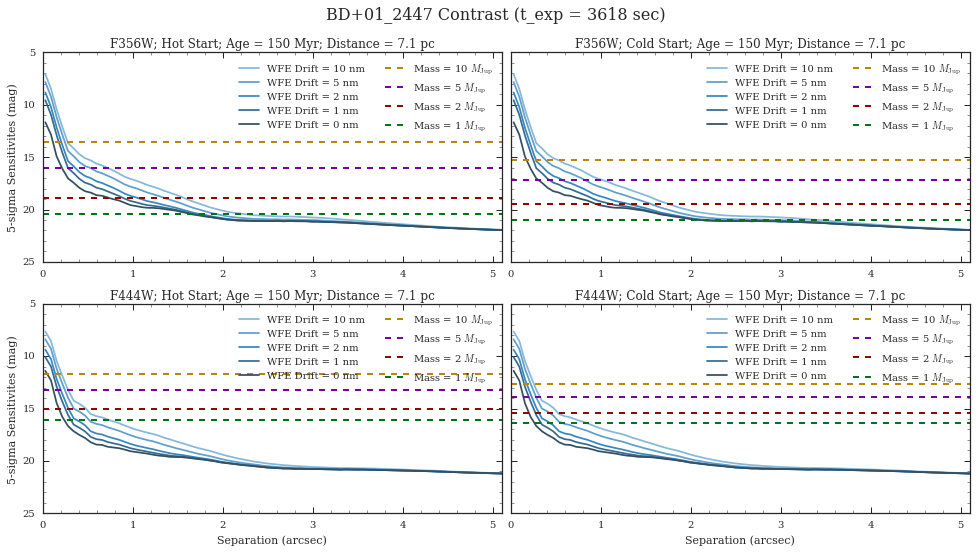

In [26]:
(source, dist, sptype, age, kmag) = ('BD+01_2447',       7.1, 'M3V', 150,  5.31)
do_all()


In [32]:
temp = obs_dict[filt_keys[0]]
temp.sat_limits(sp=nrc_utils.stellar_spectrum('M3V'), verbose=True)

F356W Saturation Limit assuming M3V source: 5.51


{u'Spectrum': 'M3V',
 u'bp_lim': 'F356W',
 u'satmag': 5.514093424917042,
 u'units': u'vegamag'}